In [2]:
import glob, os

In [3]:
def findFiles(path):
    return glob.glob(path) #return all files paths that match a specific pattern

print(findFiles('data/names/*.txt'))

['data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Vietnamese.txt', 'data/names/Chinese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/French.txt']


In [4]:
import unicodedata, string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Trương Minh Hồng'))

Truong Minh Hong


In [5]:
category_lines = dict()
all_categories = list()

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
print(all_categories)
print(category_lines['Vietnamese'][:5])

['Italian', 'Irish', 'Russian', 'Portuguese', 'Arabic', 'Czech', 'Scottish', 'Vietnamese', 'Chinese', 'Korean', 'Polish', 'Japanese', 'Spanish', 'English', 'German', 'Dutch', 'Greek', 'French']
['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']


In [11]:
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 977.5 kB/s eta 0:00:0000:0100:08
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
def letterToIndex(letter):
    return all_letters.find(letter)

#Return one-hot vector with shape (1, 57)
def letterToTensor(letter):
    tensor = torch.zeros(size = (1, n_letters))
    tensor[0][letterToIndex(letter)] = 1                
    return tensor

#return tensor with shape (lenWord, 1, n_letter)
def wordToTensor(word):
    tensor = torch.zeros(size = (len(word), 1, n_letters))  #1 for batch
    for index, letter in enumerate(word):
        tensor[index][0][letterToIndex(letter)] = 1
    return tensor

In [20]:
class RNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNN, self).__init__()
        self.hiddenSize = hiddenSize
        self.i2h = nn.Linear(inputSize+hiddenSize, hiddenSize)
        self.i2o = nn.Linear(inputSize+hiddenSize, outputSize)
        self.softmax = nn.Softmax(dim = 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
    def initHidden(self):
        return torch.zeros(size = (1, self.hiddenSize), dtype=torch.long)
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden =  self.i2h(combined)
        output = self.softmax(self.i2o(combined))
        return output, hidden

n_hidden = 50
model = RNN(n_letters, n_hidden, n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

def train(input, target):
    model.train()
    hidden = model.initHidden()
    for i in range(input.size()[0]):
        output, hidden = model(input[i], hidden)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return output, loss.item()

In [12]:
#category lines --> dictionary (languages: list of words)
#all_categories --> list of languages
import random

def randomTraining():
    #Get random language
    langIndex = random.randint(0, len(all_categories) - 1)
    category = all_categories[langIndex]

    #convert target language to one-hot
    targetTensor = torch.zeros(size = (1, len(all_categories)), dtype=torch.float32)
    targetTensor[0][langIndex] = 1
    #targetTensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    #Get random word from that language
    wordIndex = random.randint(0, len(category_lines[category]) - 1)
    word = category_lines[category][wordIndex]
    inputTensor = wordToTensor(word)
    return word, inputTensor, category, targetTensor

In [13]:
for i in range(5):
    word, inputTensor, category, targetTensor = randomTraining()
    print(f'category: {category}, word: {word}')
    print(f'inputTensor: {inputTensor.shape}')
    print(f'targetTensor: {targetTensor.shape}')
    print('*'*20)

category: Korean, word: Kang
inputTensor: torch.Size([4, 1, 57])
targetTensor: torch.Size([1, 18])
********************
category: Greek, word: Panayiotopoulos
inputTensor: torch.Size([15, 1, 57])
targetTensor: torch.Size([1, 18])
********************
category: Greek, word: Kringos
inputTensor: torch.Size([7, 1, 57])
targetTensor: torch.Size([1, 18])
********************
category: Spanish, word: Amador
inputTensor: torch.Size([6, 1, 57])
targetTensor: torch.Size([1, 18])
********************
category: Irish, word: Mckay
inputTensor: torch.Size([5, 1, 57])
targetTensor: torch.Size([1, 18])
********************


In [21]:
import time

n_iters = 100000
Loss = list()
currentLoss = 0
start = time.time()
for iter in range(1, n_iters + 1):    
    word, inputTensor, category, targetTensor = randomTraining()
    outputTensor, loss = train(inputTensor, targetTensor)
    currentLoss += loss
    if iter % 5000 == 0:
        print(f"iter {iter}/{n_iters}, loss = {loss} ({time.time()- start})")
        start = time.time()
    if iter % 1000 == 0:
        Loss.append(currentLoss/1000)
        currentLoss = 0

iter 5000/100000, loss = 2.6704931259155273 (12.673206567764282)
iter 10000/100000, loss = 1.9834073781967163 (10.993322134017944)
iter 15000/100000, loss = 2.2217791080474854 (11.135230541229248)
iter 20000/100000, loss = 2.014273166656494 (11.853767156600952)
iter 25000/100000, loss = 2.045624256134033 (11.409592151641846)
iter 30000/100000, loss = 1.98541259765625 (11.059129476547241)
iter 35000/100000, loss = 1.984750509262085 (11.239449262619019)
iter 40000/100000, loss = 2.057681083679199 (10.590036392211914)
iter 45000/100000, loss = 2.942701578140259 (10.912550210952759)
iter 50000/100000, loss = 2.0275914669036865 (10.959361791610718)
iter 55000/100000, loss = 2.066587209701538 (10.783817291259766)
iter 60000/100000, loss = 2.2250051498413086 (10.98213791847229)
iter 65000/100000, loss = 1.9828466176986694 (10.633983850479126)
iter 70000/100000, loss = 2.975053310394287 (11.374977588653564)
iter 75000/100000, loss = 2.981271743774414 (14.149189233779907)
iter 80000/100000, los

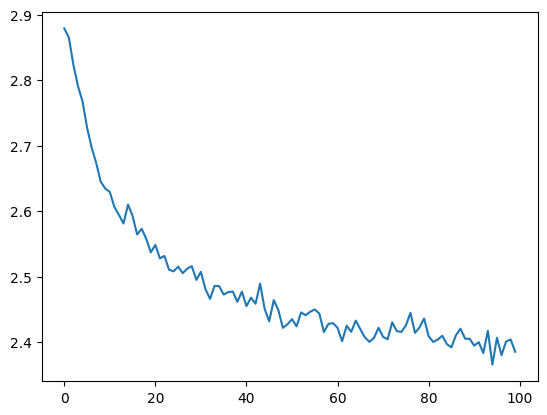

In [22]:
import matplotlib.pyplot as plt
plt.plot(Loss)
plt.show()

Evaluate

/tmp/ipykernel_3717/296913260.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_3717/296913260.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


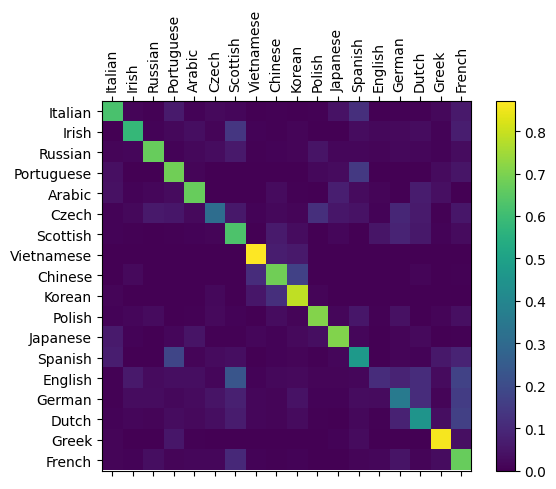

In [23]:
import matplotlib.ticker as ticker
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(wordTensor):
    with torch.no_grad():
        hidden = model.initHidden()

        for i in range(wordTensor.size()[0]):
            output, hidden = model(wordTensor[i], hidden)
    return output

# Go through a bunch of examples and record which are correctly guessed
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

for i in range(n_confusion):
    word, inputTensor, category, targetTensor = randomTraining()
    output = evaluate(inputTensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [24]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(wordToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.4f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [36]:
predict('Ngân')
predict('Tagashira')
predict('Maguire')
predict('Varane')


> Ngân
(0.4101) Vietnamese
(0.3689) Chinese
(0.2017) Irish

> Tagashira
(0.9998) Japanese
(0.0001) Dutch
(0.0001) Russian

> Maguire
(0.8440) Irish
(0.1238) Japanese
(0.0169) French

> Varane
(0.9989) French
(0.0004) German
(0.0002) Irish
